# Diffusion Models Notebook

David Picard

LIGM, Ecole Nationale des Ponts et Chaussées, Institut Polytechnique de Paris, Univ Gustave Eiffel, CNRS, France

## Generative model

We want a generative model, i.e., a model that allows us to sample from a distribution that has no closed form expression like images, text, 3D shapes of objects, etc.

One way to obtain such model is to build a push-forward operator that transforms one distribution into another. This is what is done in pseudo-random number generator to sample from unconventional distributions. For example, there are formulas to go from a number sampled from the uniform distribution to another number sampled from the Normal distribution (see the [Box-Muller transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform)).

Notation: let $P$ and $Q$ be two distributions that we want to map, and $G$ a generator mapping $P$ to $Q$ with the push-forward operator $♯$. Then
$$Q = G♯ P,$$
and
$$∀ x\sim P, G(x) \sim Q.$$



## Diffusion

One very easy way to get the push-forward is if the target distribution $Q$ is Gaussian. Then, simply adding noise (samples from a carefully chosen distribution) repeatedly will lead to a Gaussian variable because of the Central Limit Theorem ([Lyapunov or Lindeberg](https://en.wikipedia.org/wiki/Central_limit_theorem#Lyapunov_CLT), because we don't want the noise to be necessarily identically distributed).

This is analogous to the diffusion process in statistical physics: you put all your particles in the top-left corner of the box and wait a long time, they jiggle randomly, and eventually they reach the maximum entropy distribution.

If we could somehow reverse this process, i.e., jiggle the particles back to the corner of the box, we would have a practical generator. We could sample from the Gaussian distribution, which we know how to do, and then push-forward towards the distribution we are interested in.

This is exactly what Diffusion Models try to do.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device("cpu")

## Forward process

We start with the easy part: diffusing particles to random locations.

Given a _data_ distribution $P$, the forward process consists in adding noise to $x_0\sim P$ obtaining

$$ x_t \sim \mathcal{N}(\mu_t x_0, \sigma_t),$$

with $t\in[0,1]$, $\mu_0=1$, $\mu_1=0$, $\sigma_0=0$ and $\sigma_1=1$.

The forward (noising) process produces trajectories $x_t$ from $P$ to $\mathcal{N}(0,1)$.

## Iterative process

One can chose $\mu_t$ and $\sigma_t$ to correspond to an iterative scheme:

Let $\beta_0 < \dots < \beta_1$ be a schedule of $N$ steps, if
$$\mu_t = \sqrt{\prod (1-\beta_t)}, \sigma_t = \sqrt{1-\prod(1-\beta_t)}$$
then
$$x_t \sim \mathcal{N}(\sqrt{1-\beta_t}x_{t-\Delta t}, \sqrt{\beta_t}) $$
or
$$x_t = \sqrt{1-\beta_t}x_{t-\Delta t} +  \sqrt{\beta_t}\epsilon, \epsilon\sim \mathcal{N}(0,1),$$
with $Δt = 1/N$.

In [2]:
class DDPM(nn.Module):
  def __init__(self, num_timesteps,
            beta_start=0.00001, beta_end=0.02):
    super(DDPM, self).__init__()
    self.num_timesteps = num_timesteps
    self.betas = torch.linspace(beta_start, beta_end,
          num_timesteps, dtype=torch.float32)
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
    self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
    self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

  def add_noise(self, x_start, noise, timesteps):
    # The forward process
    # x_start and noise (bs)
    # timesteps (1)
    s1 = self.sqrt_alphas_cumprod[timesteps] # bs
    s2 = self.sqrt_one_minus_alphas_cumprod[timesteps] # bs
    return s1 * x_start + s2 * noise

  def add_noise_step(self, x_t, noise, timesteps):
    beta = self.betas[timesteps]
    return torch.sqrt(1-beta)*x_t + beta*noise

## Example in 1D

Going from a mixture of 2 uniform distributions to the Normal distribution.

In [3]:
class TwoSquare(nn.Module):
  def sample(self, n):
    r = (torch.rand((n,))>=0.5).float()
    x = r*(1.25+0.25*torch.rand((n,))) + (1-r)*(-1.25-0.25*torch.rand((n,)))
    return x

In [4]:
ddpm = DDPM(1000)
ts = TwoSquare()

In [5]:
n = 10000
X0 = ts.sample(n)
XT = [X0]
for t in range(1, ddpm.num_timesteps):
  XT.append(ddpm.add_noise(X0, torch.randn((n,)), t))
XT = torch.stack(XT, dim=1)

In [6]:
x_0 = ts.sample(1)
x_t = [x_0]
for t in range(1, ddpm.num_timesteps):
  x_t.append(ddpm.add_noise_step(x_t[-1], torch.randn((1,)), t))
x_t = torch.tensor(x_t).flatten()

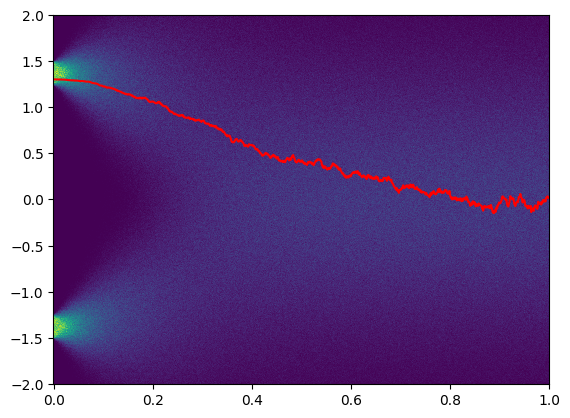

In [7]:
bins = 500
Y = torch.linspace(-2, 2, bins)
Yr = torch.cat([Y, 2*torch.ones(1)])
C = []
T = torch.linspace(0, 1, ddpm.num_timesteps)
for d in range(ddpm.num_timesteps):
  h = torch.histogram(XT[:,d].cpu(), bins=Yr.cpu(), density=True)
  C.append(h[0])
C = torch.stack(C, dim=1)
plt.pcolormesh(T, Y, C, shading='nearest')

plt.plot(torch.linspace(0, 1, ddpm.num_timesteps), x_t, '-r')

## Reverse process (denoising)

We can reverse the forward process
$$x_t = \sqrt{1-\beta_t}x_{t-\Delta t} +  \sqrt{\beta_t}\epsilon_t, \epsilon_t\sim \mathcal{N}(0,1)$$
into
$$x_{t-\Delta t} = \frac{x_t -  \sqrt{\beta_t}\epsilon_t}{ \sqrt{1-\beta_t}},$$
and iterate until we reach $x_0$.

But we need to know the exact $\epsilon$ that produced $x_t$. We don't want to memorize the $\epsilon_t$ that was sampled during the forward process, because in practice we want to be able to denoise samples for which we have forgotten the forward trajectory.

Let's learn a neural network $\epsilon_\theta$ that predicts $\epsilon_t$ from $x_t$ such that $\epsilon_\theta(x_t, t) \approx \epsilon_t$!

# Training loss

We want to optimize the parameters $\theta$ such that the network minimizes

$$\min \text{E}_{x_0\sim P, t\sim U(0,1), \epsilon\sim \mathcal{N}(0,1)}\left[ \| \epsilon - \epsilon_\theta(x_t, t)\|^2\right]$$
s.t.
$$ x_t = \mu_t x_0 +\sigma_t\epsilon$$

Alternatively, we could also regress $x_0$ (equivalent, linear relation between $x_0$ and $\epsilon$).

## Optimization

At each batch:
1. Sample $x_0$
2. Sample $\epsilon$
3. Sample $t$
4. Compute $x_t$
5. Perform 1 gradient step of $\|\epsilon - \epsilon_\theta(x_t, t)\|^2$

Very slow optimization because the Cartesian product with the possible $t$ and $\epsilon$ produces an infinite dataset that has a lot of complexity.

In [8]:
torch.set_default_device(device)

In [9]:
class DDPM(nn.Module):
  def __init__(self, num_timesteps,
            beta_start=0.00001, beta_end=0.02):
    super(DDPM, self).__init__()
    self.num_timesteps = num_timesteps
    self.betas = torch.linspace(beta_start, beta_end,
          num_timesteps, dtype=torch.float32)
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
    self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
    self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

  def add_noise(self, x_start, noise, timesteps):
    # The forward process
    # x_start and noise (bs)
    # timesteps (1)
    s1 = self.sqrt_alphas_cumprod[timesteps] # bs
    s2 = self.sqrt_one_minus_alphas_cumprod[timesteps] # bs
    return s1.unsqueeze(1) * x_start + s2.unsqueeze(1) * noise

  def add_noise_step(self, x_t, noise, timesteps):
    beta = self.betas[timesteps]
    return torch.sqrt(1-beta)*x_t + beta*noise

  def denoise_step(self, x_t, x_0, timesteps):
    # estimate noise
    s1 = self.sqrt_alphas_cumprod[timesteps]
    s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]
    noise = (xt - s1.unsqueeze(1)*x_0)/s2.unsqueeze(1)
    # denoise 1 step
    timesteps -= 1
    timesteps = timesteps.clamp(0, self.num_timesteps)
    s1 = self.sqrt_alphas_cumprod[timesteps]
    s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]
    return s1.unsqueeze(1) * x_0 + s2.unsqueeze(1) * noise

In [10]:
class TwoSquare2D(nn.Module):
  def sample(self, n):
    r = (torch.rand((n,2))>=0.5).float()
    x = r*(1.25+0.25*torch.rand((n,2))) + (1-r)*(-1.25-0.25*torch.rand((n,2)))
    return x

In [11]:
ts = TwoSquare2D()
ddpm = DDPM(1000)

In [12]:
class NoisePredictor(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_layers, num_timesteps):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_timesteps = num_timesteps
    self.in_proj = nn.Linear(in_dim, hidden_dim)
    self.layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for l in range(n_layers)])
    self.scale = nn.Parameter(torch.zeros((n_layers, 1, hidden_dim,)), requires_grad=True)
    self.out_proj = nn.Linear(hidden_dim, 2)
    self.t_emb = nn.Embedding(num_timesteps, hidden_dim)

    for l in self.layers:
      nn.init.xavier_uniform_(l.weight)
      nn.init.zeros_(l.bias)
    nn.init.zeros_(self.out_proj.weight)
    nn.init.zeros_(self.out_proj.bias)

  def forward(self, x, t):
    x = self.in_proj(x)
    t = self.t_emb(t)
    x = x + 0.1*t
    for i, l in enumerate(self.layers):
      x = x + self.scale[i]*F.gelu(l(x))
    x = self.out_proj(x)
    return x

In [13]:
model = NoisePredictor(2, 64, 4, ddpm.num_timesteps)
opt = AdamW(model.parameters(), lr=0.001)

## Training example

We predict $x_0$ instead of $\epsilon$ because it is easier to visualize.

- Blue dots: initial samples $x_0$
- Orange dots: noisy samples $x_t$
- Linked green dots: estimated $\hat{x}_0$ predicted by the neural network


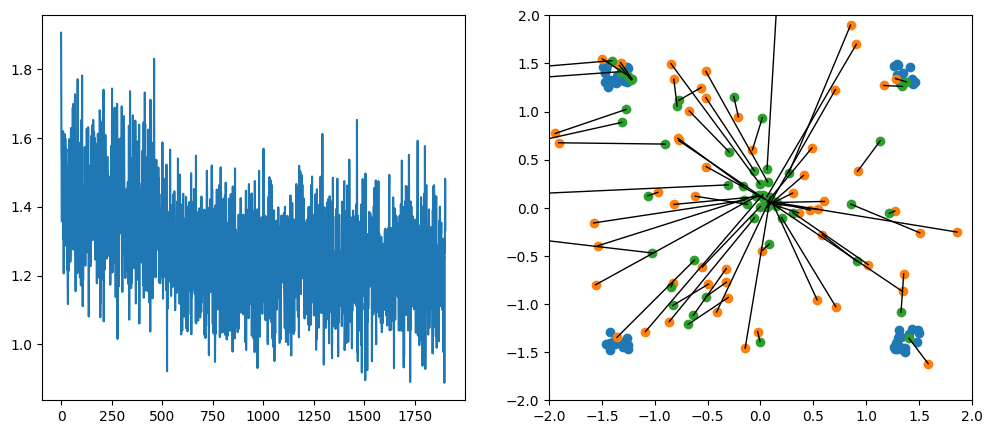

In [14]:
bs = 64
max_step = 20000
l = []
for i in range(max_step):
  opt.zero_grad()
  x0 = ts.sample(bs)
  eps = torch.randn((bs,2))
  t = torch.randint(0, ddpm.num_timesteps, (bs,))
  xt = ddpm.add_noise(x0, eps, t).detach()
  pred = model(xt, t)
  loss = (x0 - pred).square().mean()
  loss.backward()
  opt.step()

  if i%10 == 0:
    l.append(loss.item())
  if i>0 and i%1000 == 0:
    # Plot the loss curve
    x0 = x0.cpu()
    xt = xt.cpu()
    pred = pred.detach().cpu()
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(l)
    ax2.scatter(x0[:,0], x0[:,1])
    ax2.scatter(xt[:,0], xt[:,1])
    ax2.scatter(pred[:,0], pred[:,1])
    for i in range(len(xt)):
      ax2.plot([xt[i, 0], pred[i, 0]], [xt[i, 1], pred[i, 1]], 'k-', linewidth=1)
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    plt.show()


## Analysis

Orange dots that are closer to the blue ones are likely to have smaller $t$ (i.e., less noise), while orange dots futher away from the blue one are likely to have bigger $t$ (i.e., more noise).

For small $t$, the model seems to predict very well a corresponding $\hat{x}_0$ thet fits the distribution.

For larger $t$, the model seems to predict some random location centered at $(0,0)$. Strange? More on that later.

## Inference

Sample $x_1 \sim \mathcal{N}(0,1)$ and iterate
$$x_{t-\Delta t} = \frac{x_t -  \sqrt{\beta_t}\epsilon_\theta(x_t, t)}{ \sqrt{1-\beta_t}}$$
until reaching $x_0$.

If $\epsilon_\theta$ is well trained, then we should have $x_0 \sim P$.

Let's try that! We show the current $x_t$ in blue, the estimated $x_0$ predicted by the neural network in orange, and the last 2 steps as trails to get an idea of how particles move.

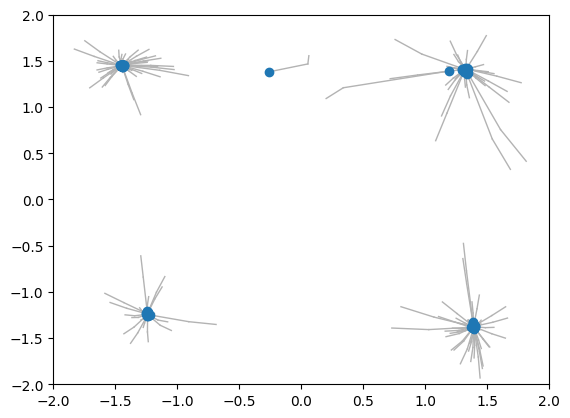

In [15]:
torch.set_default_device("cpu")
ddpm = DDPM(1000)
model = model.to("cpu")
bs = 128
xt = torch.randn((bs, 2))
xp = xt
xp1 = xp
xp2 = xp1
for t in torch.arange(2, ddpm.num_timesteps):
  t = (ddpm.num_timesteps-1 - t)*torch.ones((bs,)).long()
  x0 = model(xt, t).detach()
  xt = ddpm.denoise_step(xt, x0, t)
  if t[0]%25 == 0:
    clear_output(wait=True)
    for i in range(len(xt)):
      plt.plot([xp[i, 0], xt[i, 0]], [xp[i, 1], xt[i, 1]], 'k-', linewidth=1)
      plt.plot([xp[i, 0], xp1[i, 0]], [xp[i, 1], xp1[i, 1]], 'k-', linewidth=1)
      plt.plot([xp2[i, 0], xp1[i, 0]], [xp2[i, 1], xp1[i, 1]], 'k-', linewidth=1)
    # plt.scatter(xp[:,0], xp[:,1])
    plt.scatter(xt[:,0], xt[:,1])
    plt.scatter(x0[:,0], x0[:,1])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.show()
    xp2 = xp1
    xp1= xp
    xp = xt

clear_output(wait=True)
for i in range(len(xt)):
  plt.plot([xp[i, 0], xt[i, 0]], [xp[i, 1], xt[i, 1]], '-', color='0.7', linewidth=1)
  plt.plot([xp[i, 0], xp1[i, 0]], [xp[i, 1], xp1[i, 1]], '-', color='0.7', linewidth=1)
  plt.plot([xp2[i, 0], xp1[i, 0]], [xp2[i, 1], xp1[i, 1]], '-', color='0.7', linewidth=1)
plt.scatter(xt[:,0], xt[:,1], zorder=5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

## Magic?
How come does this work so well? Splitting the Gaussian is not easy: the target distribution does not have the same topology as the source one (from 1 mode to 4 disconnected modes) which is known to be impossible to achieve well with a neural network that as a low Lipschitz constant $L$ ([Tanielian ICML'20](https://proceedings.mlr.press/v119/tanielian20a.html) and [Issenhuth ICML'23](https://proceedings.mlr.press/v202/issenhuth23a.html)).

Here are some thoughts:
- Neural net of capability $L$ iterated $N$ times → $L^N$
- Bad prediction = noise → _random_ exploration until reaching a known zone were the network performs well

In practice, it's also convenient because if the results do not satisfy you, you can restart from a different initial noise. This is (IMHO) why diffusion is so popular to generate images: you generate until you find one that satisfy you.

## Empirical data

In practice we never have $P$ but only a finite training set $\mathcal{A} = \{x\sim P\}$.

We thus optimize

$$ min_\theta \sum_{x_0^i\in \mathcal{A}} \text{E}_{t\sim U(0,1), ϵ\sim \mathcal{N}(0,1)}\left[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right], x_t = \mu_tx_0^i + \sigma_t\epsilon, $$

or the equivalent

$$ \min_\theta \sum_{x_0^i \in \mathcal{A}} \iint \| x_0^i - f_\theta( x_t ) \|^2 p(x_t | x_0^i) p(t) dx_t dt. $$


## Single $t$

Consider the problem reduced to a single timstep $t$:

$$  \mathcal{L}_t =\int \sum_{x_0^i \in \mathcal{A}} \| x_0^i - f_\theta( x_t ) \|^2 p(x_t | x_0^i) dx_t,$$

it has a close form minimizer of the form

$$ f_t^\star (x) = \frac{\sum_{x_0^i \in \mathcal{A}} p(x | x_0^i) x_0^i}{\sum_{x_0^i \in\mathcal{A}} p(x | x_0^i)}$$

### Proof

Because $\mathcal{L}_t$ is strongly convex in $f$, its minimizers follow
    \begin{align}
        \nabla\mathcal{L}_t =& 0\\
        =&\nabla\int \sum_{x_0^i \in \mathcal{A}} \| x_0^i - f_\theta( x_t ) \|^2 p(x_t | x_0^i) dx_t\\
        =& \int \nabla \sum_{x_0^i \in \mathcal{A}} \| x_0^i - f_\theta( x_t ) \|^2 p(x_t | x_0^i) dx_t
    \end{align}
which, among other solutions, can be fulfilled if all gradients in the integral are null.

Setting $\forall x_t, \nabla \sum_{x_0^i \in \mathcal{A}} \| x_0^i - f_\theta( x_t ) \|^2 p(x_t | x_0^i) = 0$, we get
    \begin{align}
        \nabla \sum_{x_0^i \in \mathcal{A}} \| x_0^i - f_\theta( x_t ) \|^2 p(x_t | x_0^i) =& 0\\
        2\sum_{x_0^i \in \mathcal{A}} (x_0^i - f_\theta( x_t )) p(x_t | x_0^i)=&0 \\
        f_\theta(x_t)=&\frac{\sum_{x_0^i \in \mathcal{A}} p(x | x_0^i) x_0^i}{\sum_{x_0^i \in\mathcal{A}} p(x | x_0^i)}
    \end{align}
And thus $f_t^\star$ is a minimizer of $\mathcal{L}_t$.

See [Karras NeurIPS'22](https://proceedings.neurips.cc/paper_files/paper/2022/hash/a98846e9d9cc01cfb87eb694d946ce6b-Abstract-Conference.html) for an alternative derivation.

## Barycenters

$f_t^\star (x) = \frac{\sum_{x_0^i \in \mathcal{A}} p(x | x_0^i) x_0^i}{\sum_{x_0^i \in\mathcal{A}} p(x | x_0^i)}$ is the barycenter of $\mathcal{A}$ according to the Gaussian probability at time $t$

1. At $t=1$, it's uniform → the target is the average of $\mathcal{A}$
2. At $t=0$, it's a Dirac distribution centered on a single training sample

## Example

Perform the reverse process with $f_t^\star$

In [16]:
def barycenter(xt, mut, sit, x0):
  mx0 = mut * x0
  n, d = x0.shape
  n0 = (mx0**2).sum(axis=1, keepdims=True)
  nx = (xt**2).sum(axis=1, keepdims=True)
  dist2 = nx + n0.T - 2 * xt @ mx0.T
  prob = torch.exp(-dist2 / (d*sit+1e-7))
  return (prob @ x0) / (prob.sum(axis=1, keepdims=True)+1e-7)

In [17]:
def get_next(xt, xb, mu_now, mu_next, si_now, si_next, ran):
    eps = (xt - mu_now*xb)/torch.sqrt(si_now)
    x_next = mu_next*xb + torch.sqrt(si_next) * (eps + ran)
    return eps.float(), x_next.float()

def denoise(xt, x0, steps, b=0.):
  mut = torch.sin(0.5*torch.pi*torch.linspace(0.0, 1.0, steps))
  sit = torch.sin(0.5*torch.pi*(1.-torch.linspace(0.0, 1.0, steps)))
  x = [xt]
  ba = []
  for mu_now, mu_next, si_now, si_next in zip(mut[:-1], mut[1:], sit[:-1], sit[1:]):
    xt = x[-1]
    n, d = xt.shape
    xb = barycenter(xt, mu_now, si_now, x0)
    eps, x_next = get_next(xt, xb, mu_now, mu_next, si_now, si_next, b*np.random.randn(n, d))
    x.append(x_next)
    ba.append(xb)
  return torch.stack(x), torch.stack(ba)

In [18]:
torch.manual_seed(3407)
dim = 2
nb_train = 64
nb_particles = 128
nb_steps = 10000
b=0.00

x0 = torch.randn(nb_train, dim) + (torch.rand(nb_train, dim)>0.5)*8-4.
x = torch.randn(nb_particles, dim)

In [19]:
traj, traj_b = denoise(x, x0, nb_steps, b)

## Sample trajectories

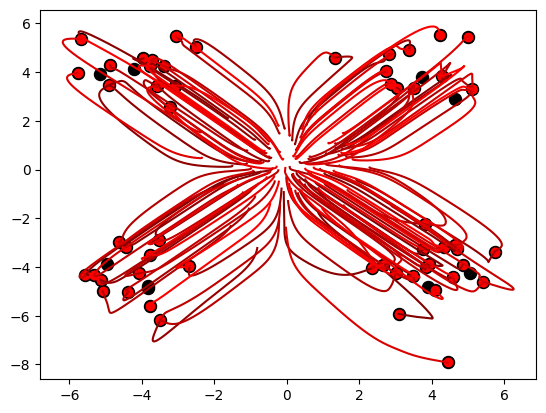

In [20]:
for i in range(nb_particles):
  color = np.array([0.5, 0., 0.]) + (i+1)/nb_particles*0.5*np.array([1., 0., 0.])
  plt.plot(traj[:,i,0], traj[:,i,1], '-', color=color)
plt.scatter(x0[:,0], x0[:,1], c='k', s=75)
plt.scatter(traj[-1,:,0], traj[-1,:,1], c='r')

## Analysis

We observe convergence to training samples because we have a perfect minimizer of the loss and we did enough steps.

Notice the _hooks_ at the begining of the trajectories: it seems that denoised samples first go towards the center before moving back towards training samples.

## Barycenter trajectories

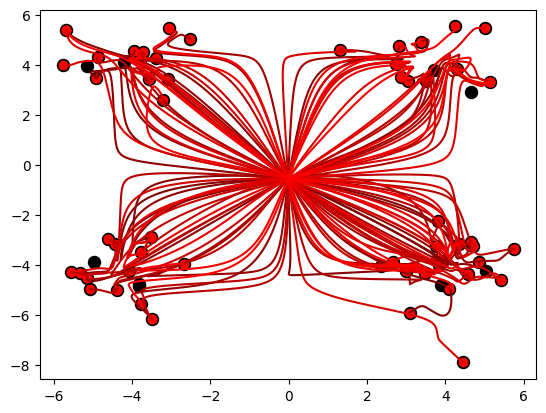

In [21]:
for i in range(nb_particles):
  color = np.array([0.5, 0., 0.]) + (i+1)/nb_particles*0.5*np.array([1., 0., 0.])
  plt.plot(traj_b[:,i,0], traj_b[:,i,1], '-', color=color)
plt.scatter(x0[:,0], x0[:,1], c='k', s=75)
plt.scatter(traj_b[-1,:,0], traj_b[-1,:,1], c='r')

## Analysis

At the begining, all barycenters are at $(0,0)$. This is because the weights are actually uniforms: from the Gaussian point of view, all training samples are equally likely and thus we predict the average of the training set.

As $t$ increases, some of the training samples get cut from the barycenter because the variance of the Gaussian has decreased below a threshold that would make them have a significant contribution. Hence, the trajectories move towards one or two modes depending on where you started.

At the end, only one training sample remains with a significant weight and we converge towards it.

## Noisy barycenters

We can model a neural network producing imperfect estimations of $x_0$ by adding noise to $f_t^\star$.

In [22]:
def noisy_barycenter(xt, mut, sit, x0, b):
  mx0 = mut * x0
  n, d = x0.shape
  n0 = (mx0**2).sum(axis=1, keepdims=True)
  nx = (xt**2).sum(axis=1, keepdims=True)
  dist2 = nx + n0.T - 2 * xt @ mx0.T
  prob = torch.exp(-dist2 / (d*sit+1e-7))
  return (prob @ x0) / (prob.sum(axis=1, keepdims=True)+1e-7) + b

def get_next(xt, xb, mu_now, mu_next, si_now, si_next):
    eps = (xt - mu_now*xb)/torch.sqrt(si_now)
    x_next = mu_next*xb + torch.sqrt(si_next) * eps
    return eps.float(), x_next.float()

def noisy_denoise(xt, x0, steps, b=0., freq=10):
  mut = torch.sin(0.5*torch.pi*torch.linspace(0.0, 1.0, steps))
  sit = torch.sin(0.5*torch.pi*(1.-torch.linspace(0.0, 1.0, steps)))
  bt = b * torch.sin(0.5*torch.pi*(1.-torch.linspace(0.0, 1.0, steps)))
  x = [xt]
  xb = 0
  ba = []
  t = 1
  for mu_now, mu_next, si_now, si_next, b_now in zip(mut[:-1], mut[1:], sit[:-1], sit[1:], bt[:-1]):
    n, d = xt.shape
    xb = noisy_barycenter(xt, mu_now, si_now, x0, b_now*np.random.randn(n, d))
    eps, x_next = get_next(xt, xb, mu_now, mu_next, si_now, si_next)
    xt = x_next
    if t%freq == 0:
      x.append(x_next)
      ba.append(xb)
    t += 1
  x.append(xt)
  ba.append(xb)
  return torch.stack(x), torch.stack(ba)

In [23]:
torch.manual_seed(3407)
dim = 2
nb_train = 64
nb_particles = 128
nb_steps = 10000
b=0.15

x0 = torch.randn(nb_train, dim) + (torch.rand(nb_train, dim)>0.5)*8-4.
x = torch.randn(nb_particles, dim)

In [24]:
traj, traj_b = noisy_denoise(x, x0, nb_steps, b)

## Sample trajectories

The trajectories are almost identical. that's because we make a lot of small steps, so the particles are actually jiggling, but it's so small that we don't se it.

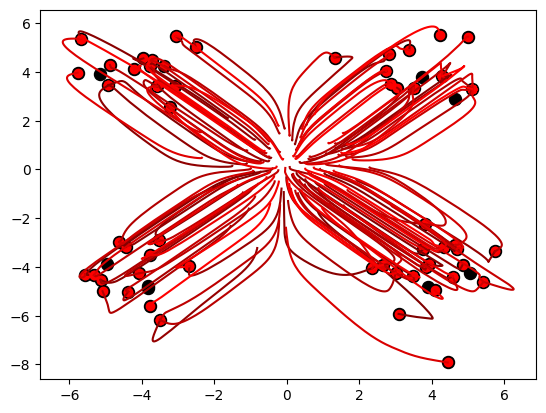

In [25]:
for i in range(nb_particles):
  color = np.array([0.5, 0., 0.]) + (i+1)/nb_particles*0.5*np.array([1., 0., 0.])
  plt.plot(traj[:,i,0], traj[:,i,1], '-', color=color)
plt.scatter(x0[:,0], x0[:,1], c='k', s=75)
plt.scatter(traj[-1,:,0], traj[-1,:,1], c='r')

## Barycenter trajectories

For the barycenters, the trajectories are much more noisy, but the behavior remain the same.

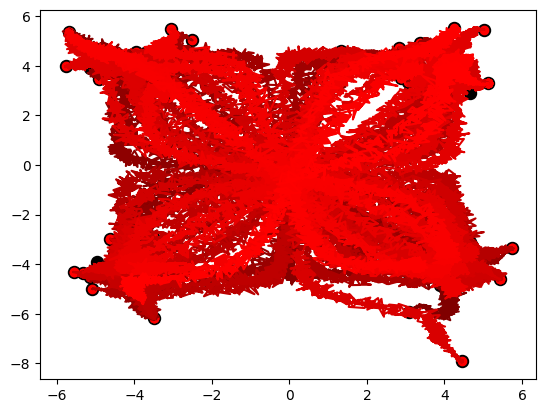

In [26]:
for i in range(nb_particles):
  color = np.array([0.5, 0., 0.]) + (i+1)/nb_particles*0.5*np.array([1., 0., 0.])
  plt.plot(traj_b[:,i,0], traj_b[:,i,1], '-', color=color)
plt.scatter(x0[:,0], x0[:,1], c='k', s=75)
plt.scatter(traj_b[-1,:,0], traj_b[-1,:,1], c='r')

## Imperfect learner

It's fine, really.

In fact, it's our only hope to generalize. If we had the capacity to optimize a neural network indistinguishable from $f^\star$, we would just spit out samples from the training set. With my colleagues, we call that jokingly Memory-GAN.

In the real world, we need to have a dataset so big compared to the capacity of the neural network that we can only memorize it imperfectly (think clustering or downsampling) and as such the reverse diffusion will lead us towards high density regions. This is also why diffusion requires bigger datasets ([Kadkhodaie ICLR'24](https://openreview.net/forum?id=ANvmVS2Yr0)).

## Conditional models

Instead of sampling from $p(x)$, We want to sample from $p(x|c)$ where $c$ can be anything that helps targeting one mode of $P$. This is the very popular text-to-image framework that made diffusion insanely popular.

Given a training set $\mathcal{A} = \{(x_0,c)\}$ of pairs $(x_0, c)$, minimize the conditional loss

$$\min_\theta \text{E}_{(x_0, c)\in \mathcal{A}, t\sim U(0,1), \epsilon\sim \mathcal{N}(0,1)} \|\epsilon - \epsilon_\theta(x_t, t, c)\|^2, $$

and that's it!

During inference, we start from a random noise $x_1$ and a condition $c$ that has been given by the user and we ieterate the reverse process like for unconditional diffusion.
I believe there is zero difference between the two. If you were to train one model for each possible $c$, then each one would be an unconditional model. We are just sharing some weights between those unconditional models by doing the conditional training.

## Classifier-Free Guidance

Usually, conditional models are not great at following perfectly the condition. This is especially true if $c$ is complex as in text.

We can enforce more adherence to $c$ by contrasting a conditional model with an unconditional one,

$$\epsilon_t = \epsilon_\theta(x_t, t, c) + \omega(\epsilon_\theta(x_t, t, c) - \epsilon_\theta(x_t, t, ∅),$$

with $\epsilon_\theta(x_t, t, ∅)$ being the unconditional model and $\omega$ the guidance weight.

## Guidance scheduler

Too much guidance tend to collapse the distribution.

What about time varying $\omega$ as proposed in [Wang TMLR'24](https://openreview.net/forum?id=SUMtDJqicd)?

1. Early stages going to the unconditional is fast
2. Later stages going away from the unconditional leads to more focus on the prompt

Lets try a toy example with Langevin sampling.

In [28]:
import jax
import jax.numpy as jnp

In [29]:
@jax.jit
def unconditional_prob(x, mu, sigma):
  k, d = mu.shape
  dist = jnp.sum((x[None,:] - mu[:,:])**2, axis=1) #1 x k
  w = 1./((2*jnp.pi)**(d/2)*sigma)
  prob = w*jnp.exp(-dist/sigma**2) # n x k
  return jnp.log(jnp.mean(prob)) # 1

vu_prob = jax.jit(jax.vmap(unconditional_prob, (0, None, None), 0))
grad_u = jax.jit(jax.vmap(jax.grad(unconditional_prob, 0), (0, None, None), 0))

In [30]:
@jax.jit
def conditional_prob(x, mu, sigma):
  dist = jnp.sum((x - mu)**2) # 1
  d = mu.shape[0]
  w = 1./((2*jnp.pi)**(d/2)*sigma)
  prob = w * jnp.exp(-dist/sigma**2) # n
  return jnp.log(prob)

vc_prob = jax.jit(jax.vmap(conditional_prob, (0, None, None), 0))
grad_c = jax.jit(jax.vmap(jax.grad(conditional_prob, 0), (0, None, None), 0))

In [31]:
def plot_gaussian(xmin, xmax, ymin, ymax, ax):
  xx, yy = jnp.mgrid[xmin:xmax:100j, ymin:ymax:100j]
  positions = jnp.vstack([xx.ravel(), yy.ravel()]).T
  print(positions.shape)
  p1 = jnp.reshape(vc_prob(positions, mu[0, ...], sigma[0]).T, xx.shape)
  p2 = jnp.reshape(vc_prob(positions, mu[1, ...], sigma[1]).T, xx.shape)
  p = jnp.reshape(vu_prob(positions, mu, sigma).T, xx.shape)
  f =  (jnp.exp(p1) - jnp.exp(p2))
  # Contourf plot
  cfset = ax.contourf(xx, yy, f, levels=200, cmap='PiYG')

## Langevin Monte-Carlo

We consider the Langevin algorithm for sampling from a distribution by realizing the following stochastic differential equation (Itô diffusion):

$$ x_{t+1} = x_t + \eta\nabla\log p(x) + \beta\epsilon_t, $$
with $\epsilon_t \sim \mathcal{N}(0,1)$ and $\eta$ a step size. This algorithm is guaranteed to sample from $P$ as $t\rightarrow\infty$.

(Previously, $\nabla\log p(x)$ was obtain by training a neural network and $\beta=0$ → DDIM/DDPM)

## Gaussian toy model

We have an unconditional distibution composed of 2 Gaussians, the unconditional probability is given by:

$$ p_u(x) = \frac{1}{4\pi \sigma_1}e^{-\frac{\|x - \mu_1\|^2}{\sigma_1^2}} + \frac{1}{4\pi \sigma_2}e^{-\frac{\|x - \mu_2\|^2}{\sigma_2^2}}.$$

The conditional distribution is always focusing on the left Gaussian and its probability is given by:

$$ p_c(x) = \frac{1}{2\pi \sigma_1}e^{-\frac{\|x - \mu_1\|^2}{\sigma_1^2}} .$$

To realize the Langevin algorithm, we consider a noisy estimator $g_c$ of the gradient of the log-probability for the conditional distribution, given by:

$$ g_c = \nabla \log p_c(x) + \beta\epsilon_c, $$

with $\epsilon_c \sim \mathcal{N}(0,1)$.

We also consider a noisy estimator $g_u$ of the gradient of the log-probability for the unconditional distribution, and with a noise correlated with $g_c$:

$$ g_u = \nabla \log p_u(x) + (1-\gamma)\beta\epsilon_c + \gamma\epsilon_u, $$
with $\epsilon_u \sim \mathcal{N}(0,1)$.

In [32]:
mu = jnp.array([[-1., 0.], [1., 0]])
sigma = jnp.array([1., 1.])
eta = 0.04
beta = 1.0
corr = 0.3
w = 5
N = 25

## Unconditional model

We first sample from $p_u$. As expeceted, LMC samples from $p_u$ given enough iterations.

In [33]:
key = jax.random.PRNGKey(3407)
x = jnp.array([[x, y] for y in [-3, -2., -1., 0, 1., 2., 3.] for x in [-4., -3., -2., -1., 0, 1., 2., 3., 4.]])
traj = [x]
for i in range(N):
  key, skey = jax.random.split(key)
  ceps = beta*jax.random.normal(skey, x.shape)
  gc = grad_c(x, mu[0, ...], sigma[0, ...]) + ceps
  key, skey = jax.random.split(key)
  gu = grad_u(x, mu, sigma) + (1-corr)*ceps + corr*beta*jax.random.normal(skey, x.shape)
  x = x + eta*(gu)
  traj.append(x)
traj = jnp.array(traj)

(10000, 2)


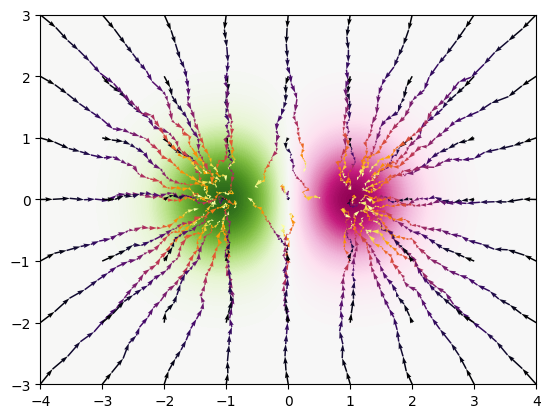

In [34]:
fig, ax = plt.subplots()
plot_gaussian(-4, 4, -3, 3, ax)
vec = traj[1:,:,:] - traj[:-1,:,:]
for i in range(len(x)):
  plt.quiver(traj[:-1,i,0], traj[:-1,i,1], vec[:,i,0], vec[:,i,1], jnp.arange(N)/N, angles='xy', units='dots', scale_units='xy', scale=1, width=1.5, cmap='inferno')


## Conditional model

We now sample from $p_c$. The output is more noisy, and this is because the samples that are far on the right don't have enough time to climb the likelihood as well as those coming from the left. This problem didn't exist with the unconditional model. It's also super slow, and we risk not arriving to the left Gaussian if there aren't enough steps.

In [35]:
key = jax.random.PRNGKey(3407)
x = jnp.array([[x, y] for y in [-3, -2., -1., 0, 1., 2., 3.] for x in [-4., -3., -2., -1., 0, 1., 2., 3., 4.]])
traj = [x]
for i in range(N):
  key, skey = jax.random.split(key)
  ceps = beta*jax.random.normal(skey, x.shape)
  gc = grad_c(x, mu[0, ...], sigma[0, ...]) + ceps
  key, skey = jax.random.split(key)
  gu = grad_u(x, mu, sigma) + (1-corr)*ceps + corr*beta*jax.random.normal(skey, x.shape)
  x = x + eta*(gc)
  traj.append(x)
traj = jnp.array(traj)

(10000, 2)


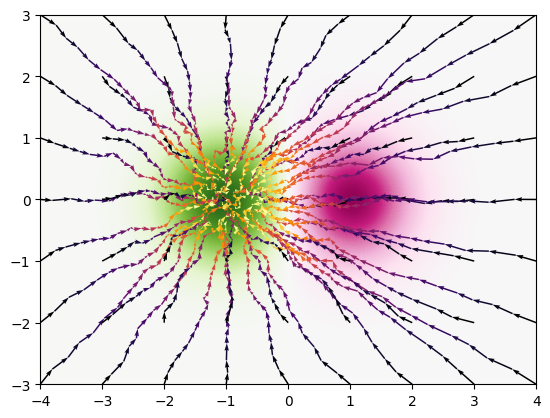

In [36]:
fig, ax = plt.subplots()
plot_gaussian(-4, 4, -3, 3, ax)
vec = traj[1:,:,:] - traj[:-1,:,:]
for i in range(len(x)):
  plt.quiver(traj[:-1,i,0], traj[:-1,i,1], vec[:,i,0], vec[:,i,1], jnp.arange(N)/N, angles='xy', units='dots', scale_units='xy', scale=1, width=1.5, cmap='inferno')


We now sample using classifier free guidance, which corresponds to the following process:

$$ x_{t+1} = x_t +\eta[ (w+1)∇\log p_c(x) - w∇\log p_u(x) ]. $$

In [37]:
key = jax.random.PRNGKey(3407)
x = jnp.array([[x, y] for y in [-3, -2., -1., 0, 1., 2., 3.] for x in [-4., -3., -2., -1., 0, 1., 2., 3., 4.]])
traj = [x]
for i in range(N):
  key, skey = jax.random.split(key)
  ceps = beta*jax.random.normal(skey, x.shape)
  gc = grad_c(x, mu[0, ...], sigma[0, ...]) + ceps
  key, skey = jax.random.split(key)
  gu = grad_u(x, mu, sigma) + (1-corr)*ceps + corr*beta*jax.random.normal(skey, x.shape)
  x = x + eta*( (1+w)*gc - w*gu )
  traj.append(x)
traj = jnp.array(traj)

(10000, 2)


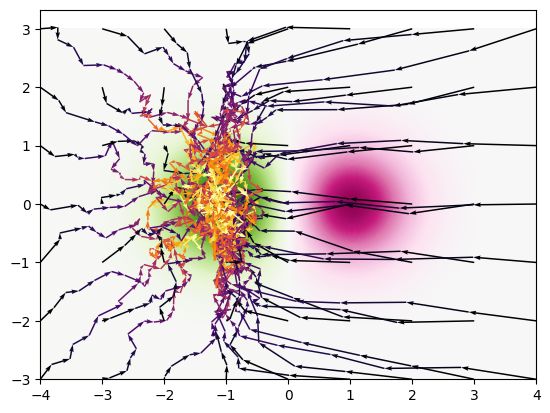

In [38]:
fig, ax = plt.subplots()
plot_gaussian(-4, 4, -3, 3, ax)
vec = traj[1:,:,:] - traj[:-1,:,:]
for i in range(len(x)):
  plt.quiver(traj[:-1,i,0], traj[:-1,i,1], vec[:,i,0], vec[:,i,1], jnp.arange(N)/N, angles='xy', units='dots', scale_units='xy', scale=1, width=1.5, cmap='inferno')


Big acceleration at the begining, too collapsed in the end.

$\Rightarrow$ Increasing weight scheduler $\omega_t = 2\omega t/N$
1. no guidance at the begining (do not go away from unconditional)
2. high guidance at the end (fully explore the mode)

In [39]:
key = jax.random.PRNGKey(3407)
x = jnp.array([[x, y] for y in [-3, -2., -1., 0, 1., 2., 3.] for x in [-4., -3., -2., -1., 0, 1., 2., 3., 4.]])
traj = [x]
for i in range(N):
  key, skey = jax.random.split(key)
  ceps = beta*jax.random.normal(skey, x.shape)
  gc = grad_c(x, mu[0, ...], sigma[0, ...]) + ceps
  key, skey = jax.random.split(key)
  gu = grad_u(x, mu, sigma) + (1-corr)*ceps + corr*beta*jax.random.normal(skey, x.shape)
  x = x + eta*( (1+w)*4*i/N*gc - w*4*i/N*gu )
  traj.append(x)
traj = jnp.array(traj)

(10000, 2)


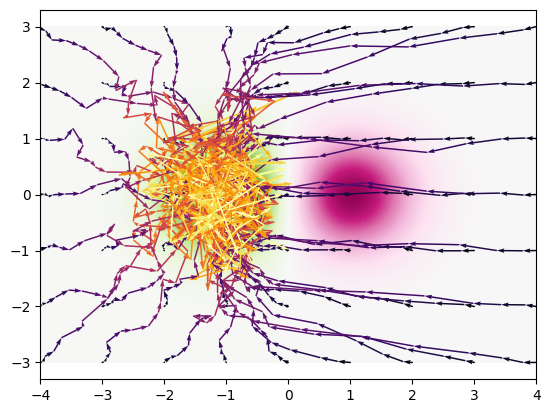

In [40]:
fig, ax = plt.subplots()
plot_gaussian(-4, 4, -3, 3, ax)
vec = traj[1:,:,:] - traj[:-1,:,:]
for i in range(len(x)):
  plt.quiver(traj[:-1,i,0], traj[:-1,i,1], vec[:,i,0], vec[:,i,1], jnp.arange(N)/N, angles='xy', units='dots', scale_units='xy', scale=1, width=1.5, cmap='inferno')
